In [22]:
%%capture
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML

display(HTML("""
<style>
    body, div, p, span, .cell, .CodeMirror, .cm-s-ipython {
        font-family: 'Times New Roman', Times, serif !important;
        font-size: 24x
    }
</style>
"""))

## About this Notebook
This note presents a way to perform image analysis for Pneuomonia detection. Using a small dataset and well  trained ResNet50 image classification model, very important concepts in image analysis can be understood. Key terms in the code are also explained. Basically it is the collection of knowledge from various sources. As, code and explanation is at same place, it will be easy to understand code and concepts at the same time.

As in many other fields, AI/Deep learning has played major role in Medical field. These models are promising in determining hiddedn patterns from the data. In many cases, these model surpass human accuracy in detecting some medical problem. For instance, in breast cancer detection, there are many cases where AI has played a significant role in early detection, by using image analysis. Likewise if not cured early, pneumonia might be life threatning, so early and accurate dectection is critical for timely treatment. Chest X-rays are the standard diagnostic tool, but interperting them is time-consuming and prone to human error. This simple project, demsnostrate how AI can assists clinicians by providing an option to accurately detect Pneumonia. This project demnostrates the potential of AI in supporting early diagnosis and reducing the workload of radiologists.

## ResNet50
ResNet50 is a powerful model for image classification, known for its ability to handle vanishing gradients through residual connections. It’s pre-trained on ImageNet, providing a strong starting point for transfer learning on medical images.

## Transfer learning
Transfer learning involves using a model pre-trained on a large dataset (like ImageNet) and fine-tuning it for a specific task. It’s ideal for medical image analysis because medical datasets are often smaller, and transfer learning reduces the need for extensive labeled data. Transfer learning can save time and resources by reusing existing models instead of traning a new model from scratch.

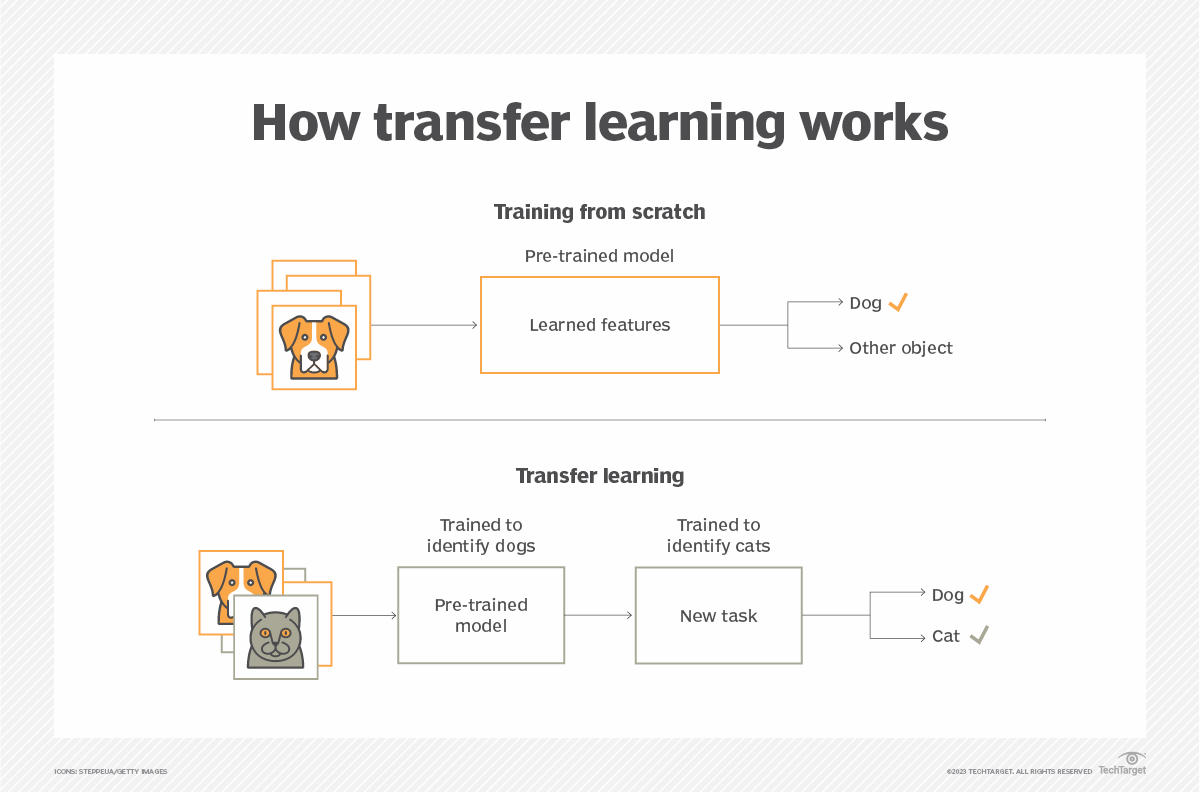

In [4]:
from IPython.display import Image
Image("how_transfer_learning_works-f.png")
#Source https://www.techtarget.com/searchcio/definition/transfer-learning

## Tranfer learning types
- Transductive transfer: Target tasks are the same but use different data sets.
- Inductive transfer:  Source and target tasks are different, regardless of the data set. Source and target data are typically labeled.
- Unsupervised transfer: Source and target tasks are different, but the process uses unlabeled source and target data. Unsupervised learning is useful in settings where manually labeling data is impractical.

## Benefits of transfer learning
- Reduced data needs
- Speeds up the training process
- Provides performance improvements
- Prevents overfitting
- Reduced computational cost
- Provides versality
## Key cases for transfer learning
- Deep learning
- Image recognization
- NLP
- Computer vision
- Speech recognition
- Object detection
  

## Dataset
- Used publicly available Chest X-ray dataset from Kaggale
- Contains labeled images for pneumonia and healthy cases, making the dataset suitable for classification task
- Contains X-ray images (JPEG format)
- Labels Pneumonia or Normal

In [23]:
#load data set and point to directory
import os
dataset_dir = "/Users/hemanta/ML_Projects_New/pneumonia_detection/chest_xray" #dataset directory
train_dir = os.path.join(dataset_dir, "train") #train data folder
test_dir = os.path.join(dataset_dir, "test") #test data folder
val_dir = os.path.join(dataset_dir, "val") #validation data folder

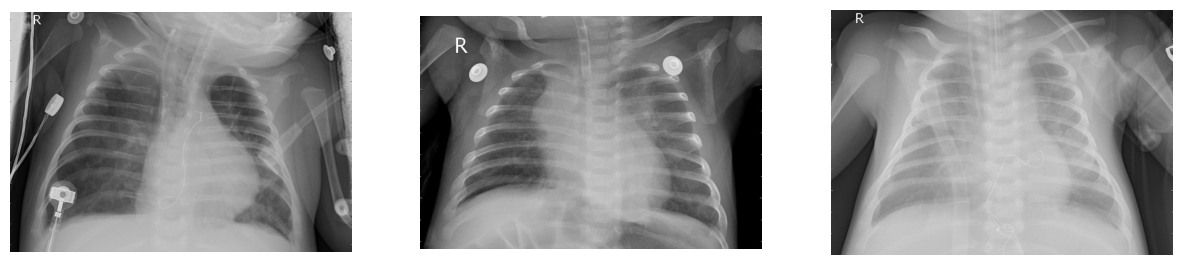

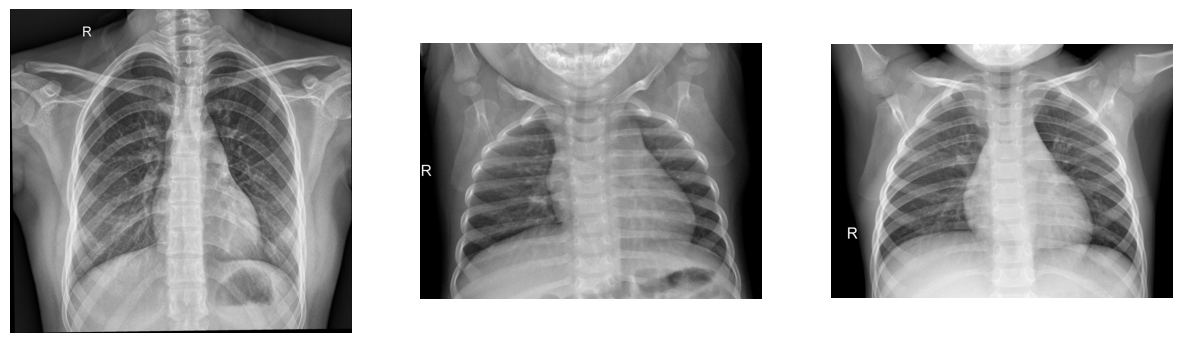

In [24]:
# Lets visualize some images
import numpy as np
import matplotlib.pyplot as plt
import cv2
def view_image_sample(directory, class_name, num_images=3):
    folder_path = os.path.join(directory, class_name)
    images = os.listdir(folder_path)[:num_images]
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# Plot sample pneumonia and normal images
view_image_sample(train_dir, "PNEUMONIA")
view_image_sample(train_dir, "NORMAL")

## Data Preprocessing


In [6]:
#Lets import data processing , and many  other modules needed for the task
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

## Steps in training model with keras
The Sequential model in Keras is a linear stack of layers that allows us to build deep learning models easily. It is useful when you have a straightforward architecture where each layer has one input and one output.
- Create a Sequential model
- Add layers (Dens, Conv2D, LSTM etc.)
- Complile the model, where we specify Optimnizer, Loss, Metrics
- Train the model with .fit()
- Evaluate and make predictions
- Analyze the error

In [43]:
# Use ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocess input for ResNet50
    rotation_range=15, #rotate image up to the value provided
    width_shift_range=0.1, # Shift image horizontally by 20%
    height_shift_range=0.1, # Shift image vertically by 10%
    zoom_range=0.1, #randomly zoom in on images
    horizontal_flip=True, #flip images horizontally
)

# Load training, validation, and test data
train_data = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), class_mode='binary', batch_size=32
)
val_data = datagen.flow_from_directory(
    val_dir, target_size=(224, 224), class_mode='binary', batch_size=32
)
test_data = datagen.flow_from_directory(
    test_dir, target_size=(224, 224), class_mode='binary', batch_size=32, shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#The ImageDataGenerator in Keras is used 
- for data augmentation and real-time image preprocessing during training
- This helps to increase the diversity of images without increasing the dataset size.
# Class mode
- Binary: For binary classification, labels will be 0 or 1
- Categorical: for multi-class classification ; more than two classes, labels will be one - hot encoded
- Sparse: similar to categorical, but labels are integer encoded instead of one - hot
- Input: when input and output images are the same (e.g. in autoencoders)
- None: no labels are returned (for unsupervised learning)

## Use transfer learning to build the model

## About ResNet50
- it is a 50 layer deep Convolutional Neural Network designed for image classification
- it is a part of the ResNet (Residual Network) family, which introduce skip connections to train deep networks effectively

# Why use ResNet50
- Avoids vanishing gradients using skip connections (residual blocks)
- pretrained model available (imagenet weights) for transfer learning
- performs well on complex image classification tasks (e.g. ImageNet)
- supports fine-tuning to adapt to new datasets

## Some model descriptors
- Input shape defined the expected input image size; 224 by 224 pixels with 3 color channels (RGB)
- Include_top; option to either remove or not the fully connected (FC) layers, keeping only the convolutional layers
- Relu: f(x) = max(0, x);
- if x>0, output x (linear),  if x<=0, output is 0 (non-linear suppression of negative values)
# Why use ReLu
- prevents vanishing gradient problem (unlike sigmoid or tanh)
- comoputationally efficient  (just thresholding at 0)
- works well in deep networks due to its linear behavior for positive values
- Use ReLU in hidden layers of deep networks
- use leaky ReLU when you face dyingReLU problem
- Avoid ReLU in output layers

In [44]:
# Load ResNet50 base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    resnet_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Sigmoid
- Output is always between 0 and 1
- if x is large positive , output is 1
- if x is large negative, output is 0
- if x is 0, then output is 0.5
- Sigmoid is useful for binary classification
- interpretable as a probability
- smooth and differentiable for optimization

# problem with sigmoid
- saturation problem (vanishing gradient): if x is very large or very small, the gradient is almost 0, slowing down learning
- not ideal for hidden layers: sigmoid outputs are mostly 0 or 1, which causes the neurons to become inactive

## Activation function to be used on output
- general regression: activation is none (linear)
- only positive values needed : activation is relu
- bounded between 0 and 1: activation function is sigmoid
- bounded between -1 and 1, activation is tanh

## Optimizer in ANN
- An optimization algorithm finds the value of the parameters (weights) that minimize the error when mapping inputs to outputs. Its primary role is to minimize the models error or loss function, enhancing performance
- These specialized algorithms facilitate the learning process of neural networks by iteratively refining the weights and biases based on the feedback received from the data. 
-  each equippied with distinct updates rules, learning rates, and momentum strateratiges, Well known optimizers are:
-  stochastic gradient descent (SGD)
-   Adam
-   RMSProp
- minibatch gradient descent
- adagrad
- AdaDelta
## More important terms in deep learning
- Epoch – The number of times the algorithm runs on the whole training dataset.
- Sample – A single row of a dataset.
- Batch – It denotes the number of samples to be taken for updating the model parameters.
- Learning rate – It is a parameter that provides the model a scale of how much model weights should be updated.
- Cost Function/Loss Function – A cost function is used to calculate the cost, which is the difference between the predicted value and the actual value.
- Weights/ Bias – The learnable parameters in a model that controls the signal between two neurons.

## Gradient descent works as follows:

- Initialize Coefficients: Start with initial coefficients.
- Evaluate Cost: Calculate the cost associated with these coefficients.
- Search for Lower Cost: Look for a cost value lower than the current one.
- Update Coefficients: Move towards the lower cost by updating the coefficients’ values.
- Repeat Process: Continue this process iteratively.
- Reach Local Minimum: Stop when a local minimum is reached, where further cost reduction is not possible.

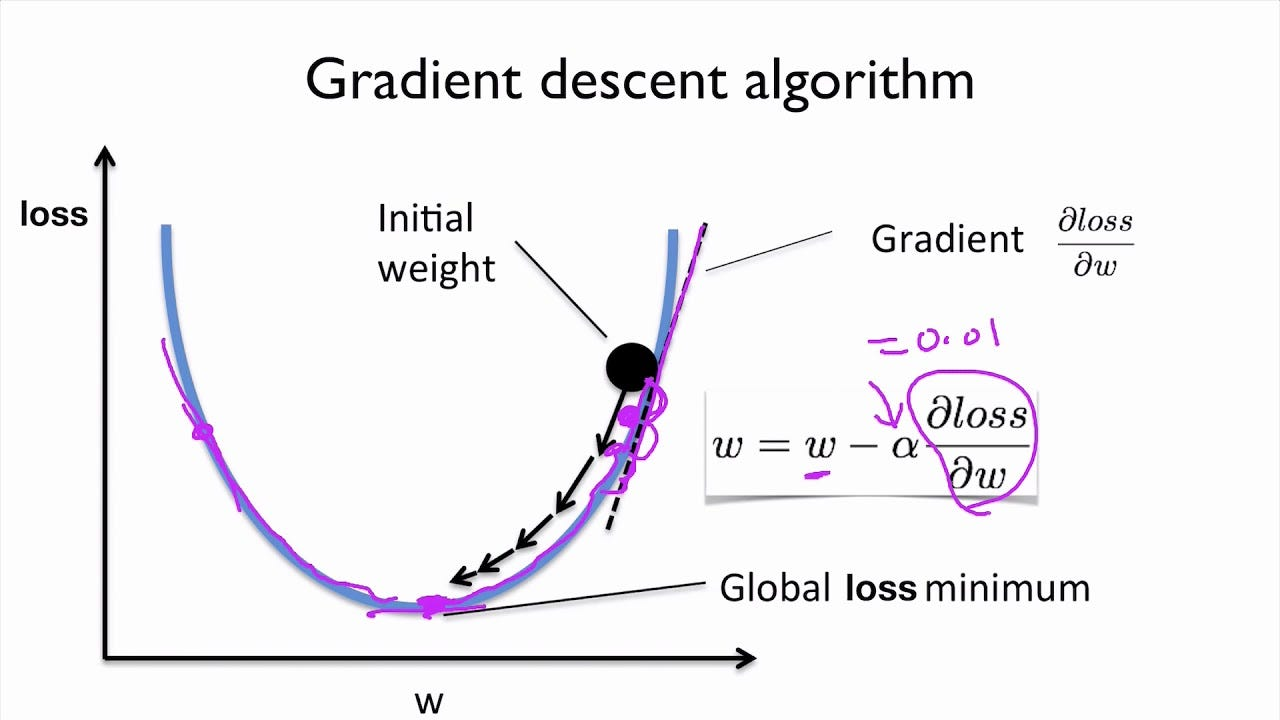

In [8]:
#source: https://www.youtube.com/watch?v=b4Vyma9wPHo
from IPython.display import Image
Image("gradient_descent.jpg")

Gradient descent works best for most purposes. However, it has some downsides too. It is expensive to calculate the gradients if the size of the data is huge. Gradient descent works well for convex functions, but it doesn’t know how far to travel along the gradient for nonconvex functions.

## Stochastic gradient descent
In stochastic gradient descent, instead of processing the entire dataset during each iteration, we randomly select batches of data. This implies that only a few samples from the dataset are considered at a time, allowing for more efficient and computationally feasible optimization in deep learning models.

Since we are not using the whole dataset but the batches of it for each iteration, the path taken by the algorithm is full of noise as compared to the gradient descent algorithm. Thus, SGD uses a higher number of iterations to reach the local minima. Due to an increase in the number of iterations, the overall computation time increases. But even after increasing the number of iterations, the computation cost is still less than that of the gradient descent optimizer. So the conclusion is if the data is enormous and computational time is an essential factor, stochastic gradient descent should be preferred over batch gradient descent algorithm.

stochastic gradient descent takes a much more noisy path than the gradient descent algorithm when addressing optimizers in deep learning. Due to this, it requires a more significant number of iterations to reach the optimal minimum, and hence, computation time is very slow. To overcome the problem, we use stochastic gradient descent with a momentum algorithm.

## Mini batch gradient descent
In this variant of gradient descent, instead of using all the training data, we only use a subset of the dataset to calculate the loss function. Since we use a batch of data instead of the whole dataset, we need fewer iterations. That is why the mini-batch gradient descent algorithm is faster than both stochastic gradient descent and batch gradient descent algorithms. This algorithm is more efficient and robust than the earlier variants of gradient descent. As the algorithm uses batching, you do not need to load all the training data into memory, which makes the process more efficient to implement. Moreover, the cost function in mini-batch gradient descent is noisier than the batch gradient descent algorithm but smoother than that of the stochastic gradient descent algorithm. Because of this, mini-batch gradient descent is ideal and provides a good balance between speed and accuracy.

Despite all that, the mini-batch gradient descent algorithm has some downsides too. It requires a hyperparameter called ‘mini-batch-size,’ which you must tune to achieve the required accuracy. A batch size of 32 is generally appropriate for almost every case. Also, in some cases, it results in poor final accuracy. 

## Adaptive gradient descent (Adagrad)
The adaptive gradient descent algorithm is slightly different from other gradient descent algorithms. This is because it uses different learning rates for each iteration. The change in learning rate depends upon the difference in the parameters during training. The more the parameters get changed, the more minor the learning rate changes. This modification is highly beneficial because real-world datasets contain sparse as well as dense features. So it is unfair to have the same value of learning rate for all the features. 

The benefit of using Adagrad is that it abolishes the need to modify the learning rate manually. It is more reliable than gradient descent algorithms and their variants, and it reaches convergence at a higher speed.

One downside of the AdaGrad optimizer is that it decreases the learning rate aggressively and monotonically. There might be a point when the learning rate becomes extremely small. This is because the squared gradients in the denominator keep accumulating, and thus the denominator part keeps on increasing. Small learning rates prevent the model from acquiring more knowledge, which compromises its accuracy.



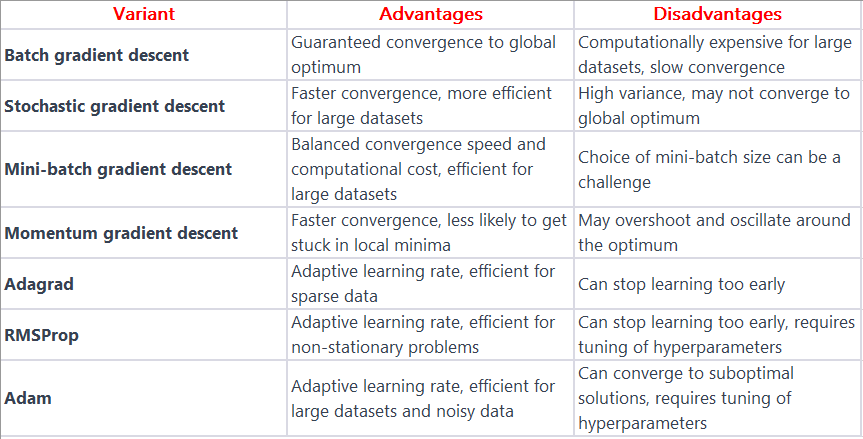

In [15]:
Image("comparison.png")

## Binary cross entropy loss
- Binary cross entropy loss, also known as log loss, is commonly used for binary classification tasks. It measures how well a probability distribution predicted by a model aligns with the actual labels
- penalty for incorrect predictions: Loss is small when the predicted probability is close to the actual class label and large otherwise
- Logarithmic scaling: Incorrect predictions are penalized heavily, preventing the model from making overconfident wrong predictions
- Derivative behavior: the loss is sensitive to small probability differences, making it effective in training deep learning model
# Common applications include:
- binary classification (e.g. spam detectiion, medical diagnose, fraud detection)
- multi label classification (where each labels is independently classified as 0 or 1)
- logistic regression models in machine learning 

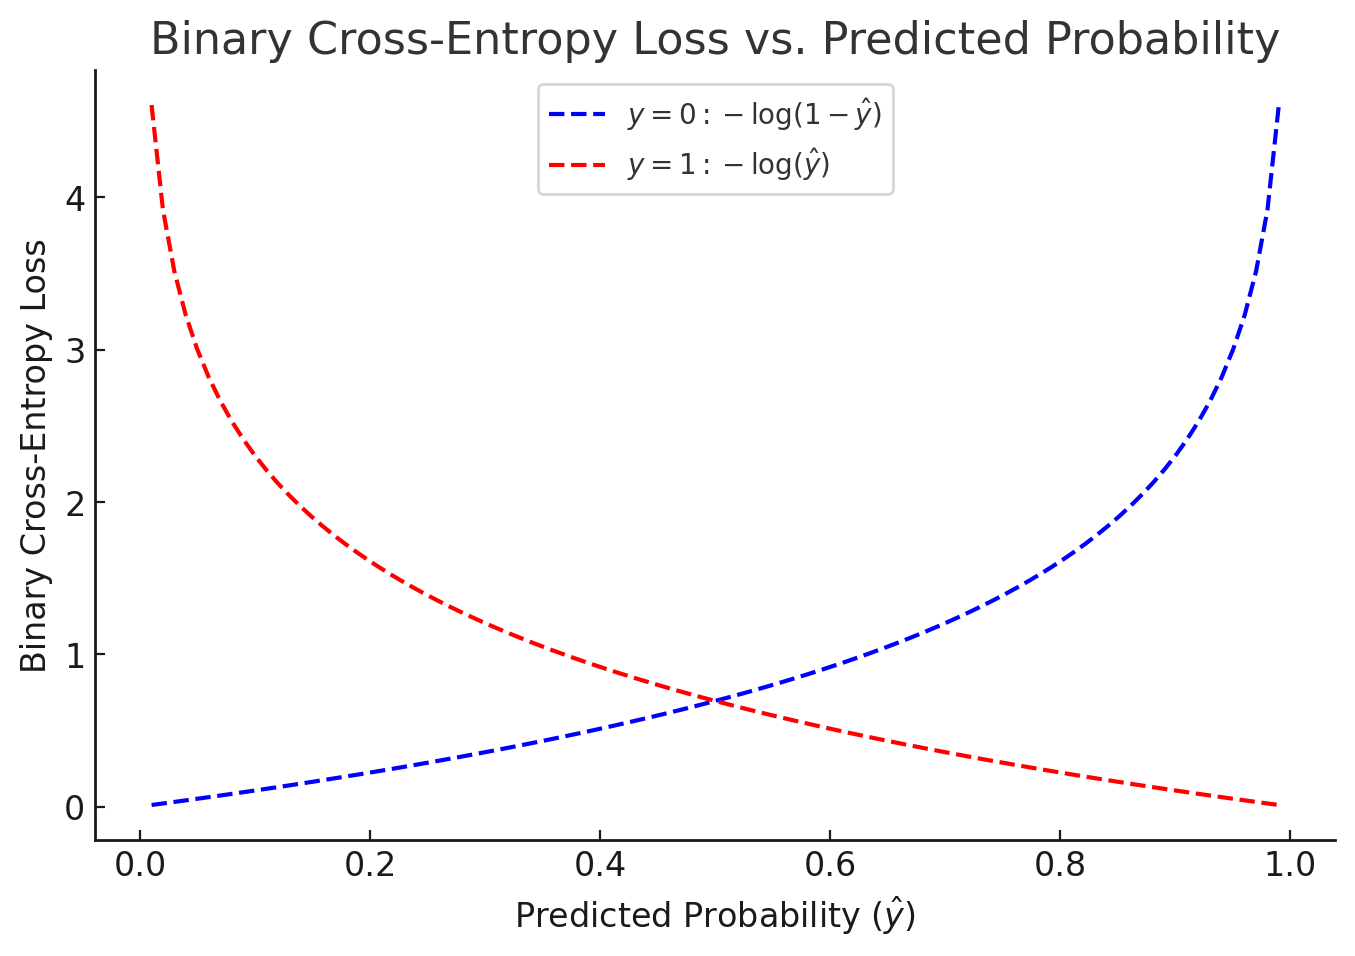

In [24]:
Image("binary_loss.png")

- The blue dashed curve represents the loss when the true label is 0 (y =0), given by -log(1-y_pred). The loss is low when y_pred is close to 0 and increases sharply as y_pred approaches 1
- The red dashed curve represents the loss when the true label 1 (y=1), given by -log(y_pred). The loss is low when y_pred is close to 1 and increase sharply as y_pred approaches 0
- Near 0 or 1 the loss inceases steeply, discouraging incorrect confident predictions
- Correct predictions (y_pred = y) have minimal loss, encouraging the model to push probabilities close to the true label
- This behaviour make binary cross entropy loss effective for training models using gradient descent, as the gradient magnitude depends on the confidence of incorrect predictions

## Train model

In [48]:
# Set up early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping]
)

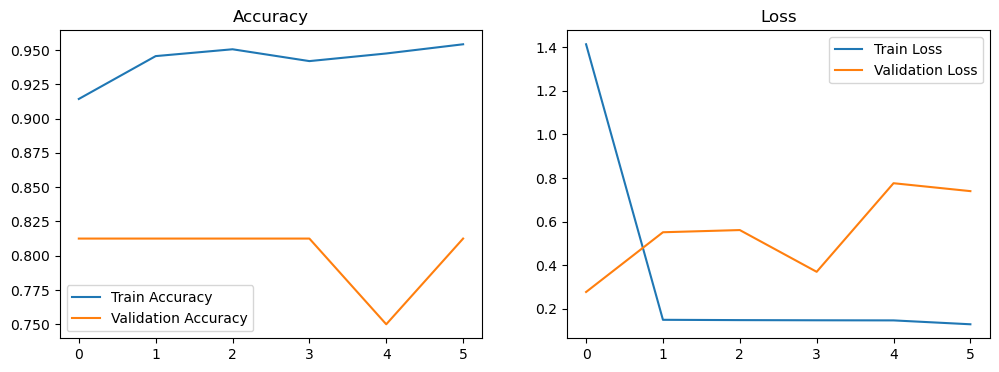

20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7390 - loss: 1.3404
Test Accuracy: 83.49%


In [12]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_history(history)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

We can observe from these plots that the parameters we used for the training process is not good enough,  this might be due to the number of data - points or due to parameters we used. These parameters can be tuned to obtained better perfromance of the model. Due to computational efficieny, I am displaying these images only for reference.

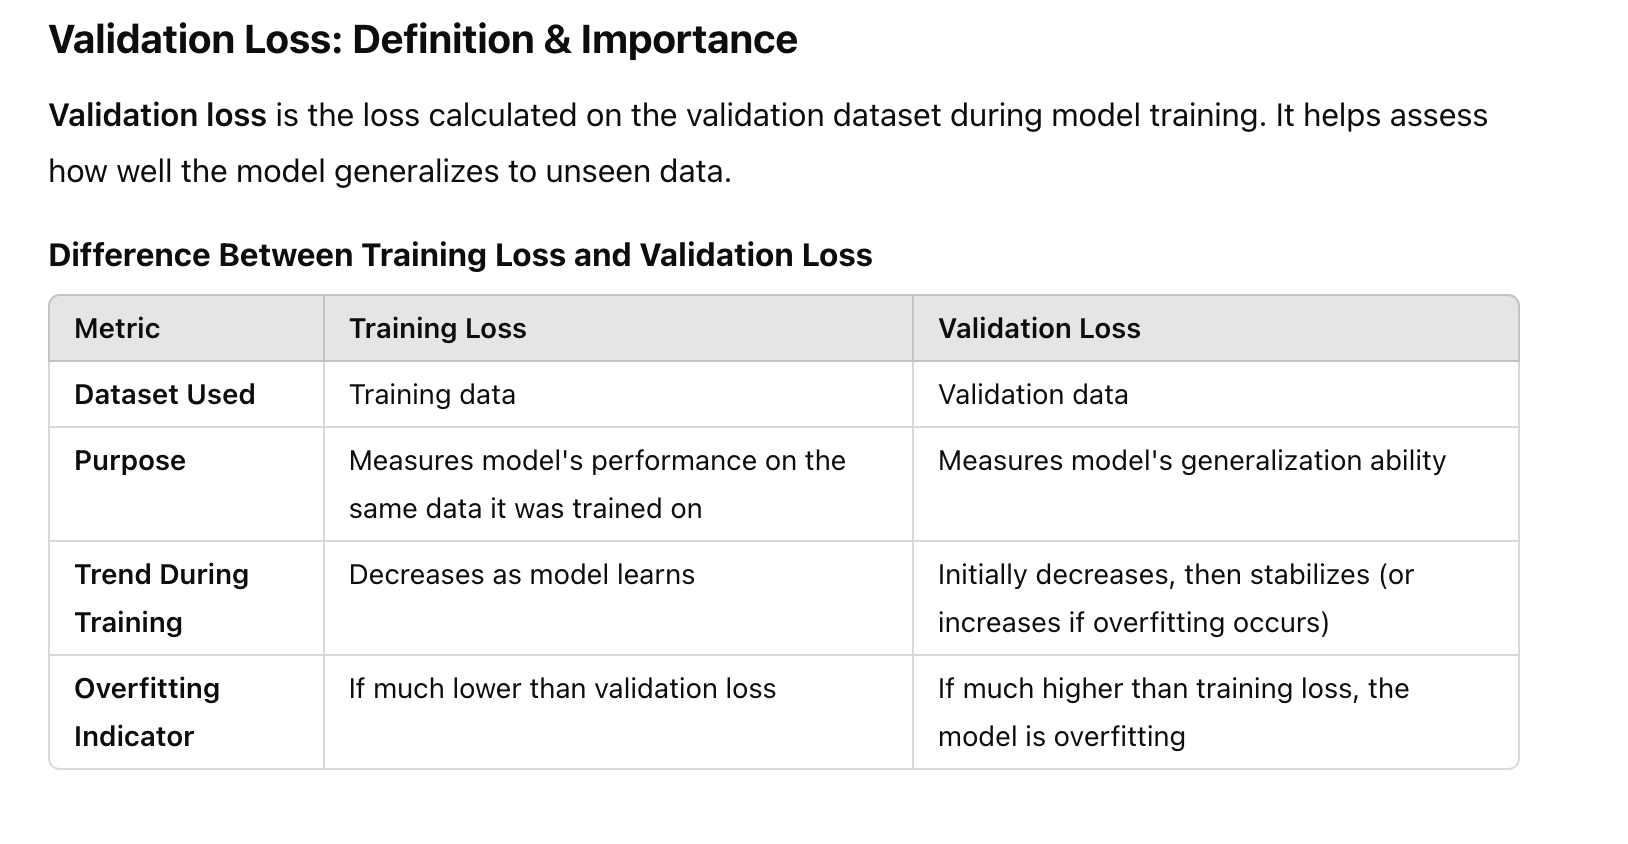

In [25]:
Image("validation_loss.png")

## Importance of validation loss
- Detects Overfitting: if validation loss starts increasing while training loss keeps decreasing, the  model is  memorizing training data rather than learning useful patterns
- Helps in Hyperparameter tuning: We can optimize learning rate, batch size, regularization (L1/L2), dropout, etc., by monitoring validation loss
- Early stopping criteria: Many training frameworks use validation loss to stop training early when it stops improving

## Dropout
- During training a fraction of neurons in a layer is randomly set to zero at each forward pass
- This forces the network to learn redundant and robust representations, preventing reliance on specific neurons
- During testing dropout is turned off, and all neurons are active, but their activations are scaled down proportionally
- mathematically, if a neurons activation is $a'_{i}$ = $a_{i}$.$m_{i}$/p
- where $m_{i}$ is a mask ( 1 with probability p, 0 otherwise)
- p is the keep probability (e.g. 0.5 means 50% of neurons are kept)

## why dropout
- prevent overfitting by reducing co-adpation of neurons
- improves generalization by making the model robust to small variations
- Acts as ensemble learning, as different subnetworks are trained in each iteration

## When to use dropout
- Use dropout in hidden layers, not in input or output layers
- Recommended dropout rates are, 0.2 - 0.5 for hidden layers
- Avoid dropout in batch normalization layers as they already regularize

## Ways to prevent overfitting in Artificial Neural Networks (ANNs)
- USe regularization techniques such as dropout
- Use L1 and L2 (Lasso and Ridge) Regularization
- Batch Normalization; best for deep networks , and convolution layers

## Data related techniques
- Data Augmentation: Artifically increase datasize by applying transformations like rotation, flipping, and noise
- Obtain more training data
- Noisy labels/ label smoothing: Replace true labels y with smoothed values to prevent overconfidence
- loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
## Architectural Ajustments
- Reduced model complexity
- Early stopping: Stops training when validation loss stops improving
## Optimizers and training adjustments
- Learning rate scheduling : adjust the learning rate dynamically to prevent overfitting
- Mini batch training: Using small batches (32-128 samples) improves generalization
- Gradient clipping: prevents large updates that can led overfitting


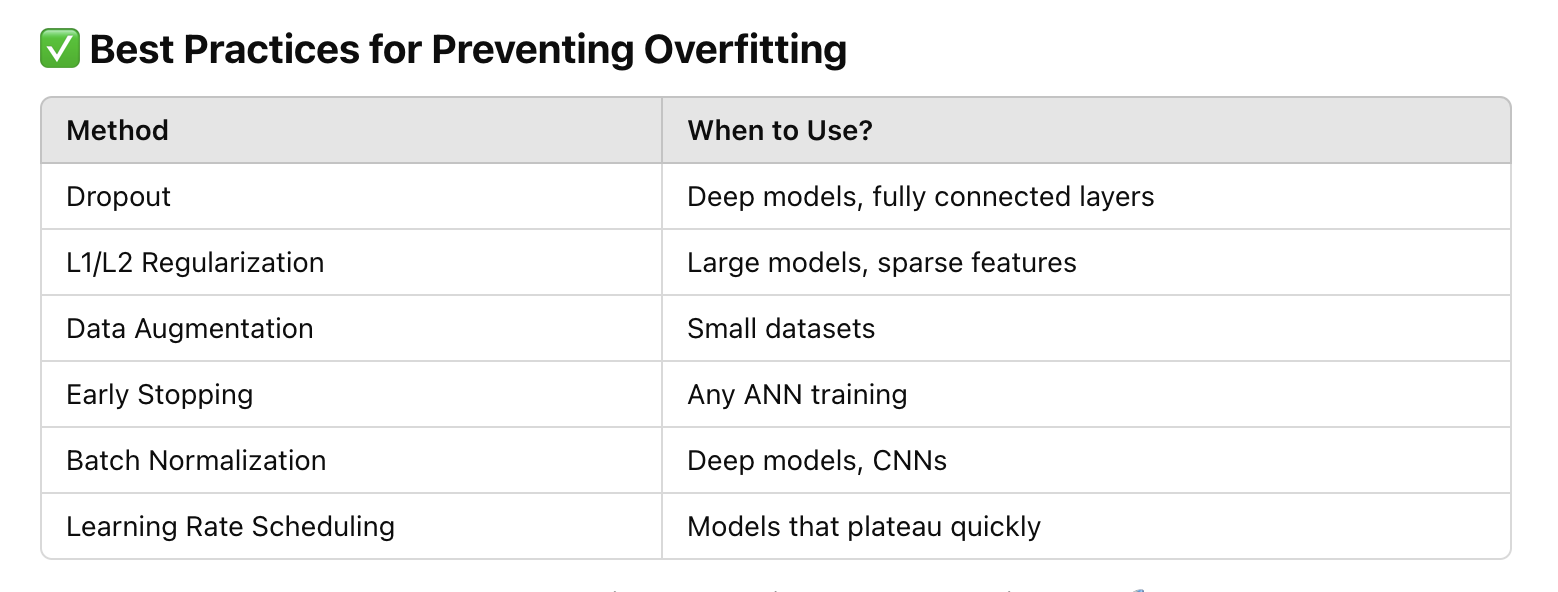

In [26]:
Image("best_practice_overfitting.png")

# Important deep learning terms
- Epoch – The number of times the algorithm runs on the whole training dataset.
- Sample – A single row of a dataset.
- Batch – It denotes the number of samples to be taken to for updating the model parameters.
- Learning rate – It is a parameter that provides the model a scale of how much model weights should be updated.
- Cost Function/Loss Function – A cost function is used to calculate the cost, which is the difference between the predicted value and the actual value.
- Weights/ Bias – The learnable parameters in a model that controls the signal between two neurons.


20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
              precision    recall  f1-score   support

      Normal       0.92      0.63      0.75       234
   Pneumonia       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



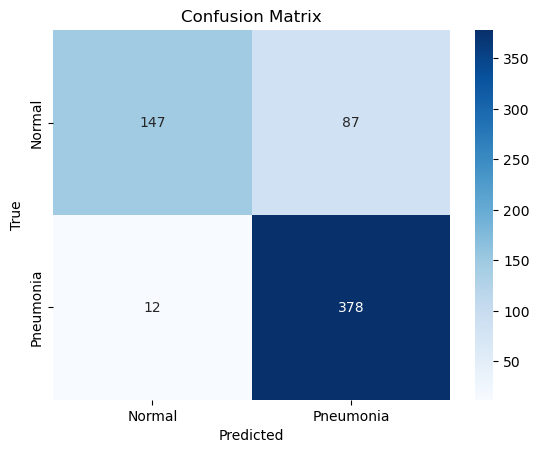

In [14]:
#Get predictions
test_data.reset()  # Ensure data order matches labels
predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype('int32').flatten()
true_classes = test_data.classes

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Analysis of confusion matrix

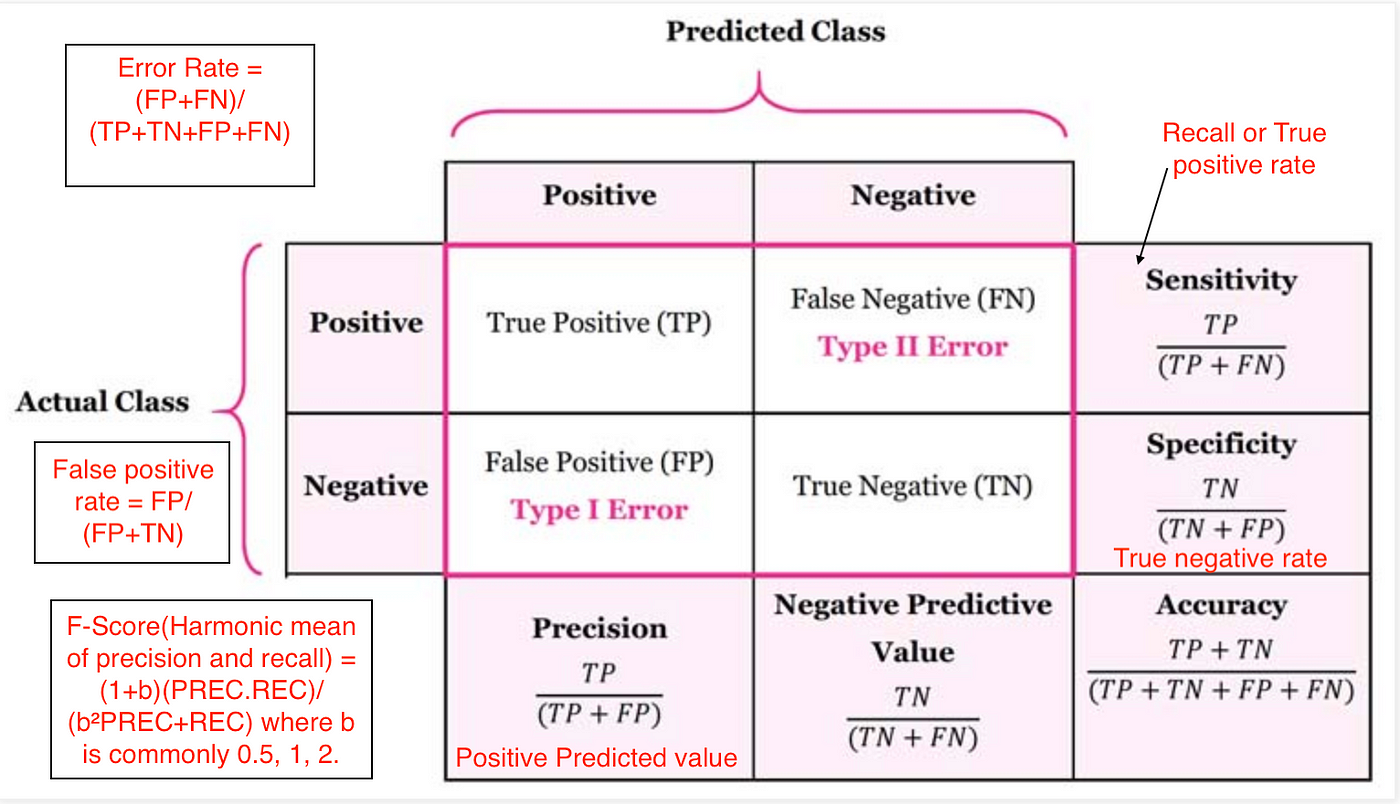

In [28]:
Image("confusion_matrix_ana.png")

Various parameters from this confusion matrix can be used to analysis the model performance. we can calculate precision, recall and others. we can see the number of false negative are high, which is not good for a model to detect the medical problems. There is huge room for improvements of this model.